# GAN Mejorada (Improved GAN)

Este cuaderno implementa una versión mejorada de la GAN para obtener datos sintéticos de mayor calidad.

**Mejoras Implementadas:**
1.  **Arquitectura:** Mayor capacidad (64 hidden units, 2 capas LSTM) y Dropout (0.2).
2.  **Entrenamiento:** Learning Rate reducido (0.0002) y optimizador Adam con betas (0.5, 0.999).
3.  **Estabilización:** Label Smoothing (Etiquetas reales = 0.9).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import sys
import os

# Añadir el directorio raíz al path
sys.path.append(os.path.abspath('..'))

from src.data_loader import download_data
from src.preprocessing import DataPreprocessor, create_sequences

## 1. Carga y Preparación de Datos

In [2]:
# Configuración
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-11-29'
SEQ_LEN = 24
BATCH_SIZE = 64 # Aumentamos batch size para mayor estabilidad
DATA_DIR = '../data/processed'

# Cargar datos
csv_filename = f"{TICKER}_scaled.csv"
csv_path = os.path.join(DATA_DIR, csv_filename)

if os.path.exists(csv_path):
    print(f"Cargando datos existentes desde: {csv_path}")
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    df.index.name = 'Date'
else:
    print(f"Descargando datos...")
    df = download_data(TICKER, START_DATE, END_DATE, save_dir=DATA_DIR)

# Preprocesar
# Preprocesar (Si los datos ya están escalados, solo cargar)
if 'Close_Scaled' in df.columns:
    data_scaled = df[['Close_Scaled']].values
else:
    preprocessor = DataPreprocessor()
    data_scaled = preprocessor.fit_transform(df, ['Close'])
preprocessor = DataPreprocessor()
sequences = create_sequences(data_scaled, SEQ_LEN)

# DataLoader
X_train = torch.tensor(sequences, dtype=torch.float32)
dataset = TensorDataset(X_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Datos de entrenamiento: {X_train.shape}")

Cargando datos existentes desde: ../data/raw/AAPL_2015-01-01_2025-11-29.csv
Datos de entrenamiento: torch.Size([2720, 24, 1])


## 2. Arquitectura Mejorada

Definimos modelos con más capas y dropout.

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return self.sigmoid(output)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]
        output = self.linear(last_hidden)
        return self.sigmoid(output)

## 3. Configuración del Entrenamiento

Usamos un LR más bajo y Label Smoothing.

In [4]:
# Hiperparámetros Mejorados
NOISE_DIM = 10
HIDDEN_DIM = 64  # Aumentado de 32
FEATURE_DIM = 1
NUM_EPOCHS = 200 # Aumentado para compensar menor LR
LR = 0.0002      # Reducido de 0.001
BETA1 = 0.5      # Estándar para GANs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciar
generator = Generator(input_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM, output_dim=FEATURE_DIM, num_layers=2).to(device)
discriminator = Discriminator(input_dim=FEATURE_DIM, hidden_dim=HIDDEN_DIM, output_dim=1, num_layers=2).to(device)

# Loss y Optimizadores
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

## 4. Bucle de Entrenamiento con Label Smoothing

In [5]:
G_losses = []
D_losses = []

print("Iniciando entrenamiento mejorado...")

for epoch in tqdm(range(NUM_EPOCHS)):
    for i, (real_data,) in enumerate(dataloader):
        real_data = real_data.to(device)
        batch_size = real_data.size(0)
        
        # Label Smoothing: Reales son 0.9 en vez de 1.0
        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --- Entrenar Discriminador ---
        optimizer_D.zero_grad()
        
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, SEQ_LEN, NOISE_DIM).to(device)
        fake_data = generator(z)
        
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        
        optimizer_D.step()
        d_loss = d_loss_real + d_loss_fake

        # --- Entrenar Generador ---
        optimizer_G.zero_grad()
        
        # Para el generador, queremos que el discriminador diga 1.0 (o 0.9)
        # Usamos 1.0 aquí para forzar al generador a ser lo más real posible
        target_labels = torch.ones(batch_size, 1).to(device) 
        
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, target_labels)
        
        g_loss.backward()
        optimizer_G.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print("Entrenamiento finalizado.")

Iniciando entrenamiento mejorado...


 10%|█         | 20/200 [00:35<05:25,  1.81s/it]

Epoch [20/200] | D Loss: 1.0567 | G Loss: 1.2703


 20%|██        | 40/200 [01:12<04:44,  1.78s/it]

Epoch [40/200] | D Loss: 1.2296 | G Loss: 0.9373


 30%|███       | 60/200 [01:47<04:09,  1.78s/it]

Epoch [60/200] | D Loss: 1.3504 | G Loss: 0.8353


 40%|████      | 80/200 [02:24<03:40,  1.83s/it]

Epoch [80/200] | D Loss: 1.4064 | G Loss: 0.8012


 50%|█████     | 100/200 [02:59<02:55,  1.76s/it]

Epoch [100/200] | D Loss: 1.3669 | G Loss: 0.8009


 60%|██████    | 120/200 [03:35<02:21,  1.76s/it]

Epoch [120/200] | D Loss: 1.3739 | G Loss: 0.7950


 70%|███████   | 140/200 [04:11<01:47,  1.79s/it]

Epoch [140/200] | D Loss: 1.3751 | G Loss: 0.7963


 80%|████████  | 160/200 [04:46<01:10,  1.77s/it]

Epoch [160/200] | D Loss: 1.3798 | G Loss: 0.8090


 90%|█████████ | 180/200 [05:22<00:35,  1.79s/it]

Epoch [180/200] | D Loss: 1.3783 | G Loss: 0.7987


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]

Epoch [200/200] | D Loss: 1.3757 | G Loss: 0.7970
Entrenamiento finalizado.


## 5. Evaluación de Resultados

Visualizamos pérdidas y comparamos distribuciones (PCA/t-SNE) inmediatamente.

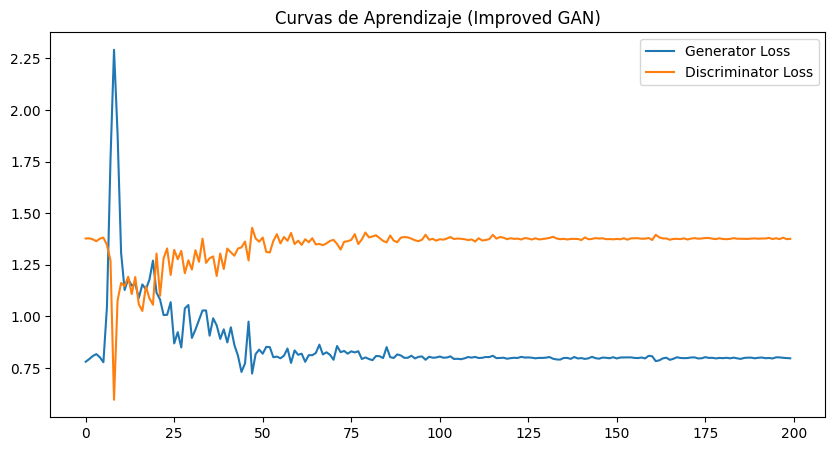

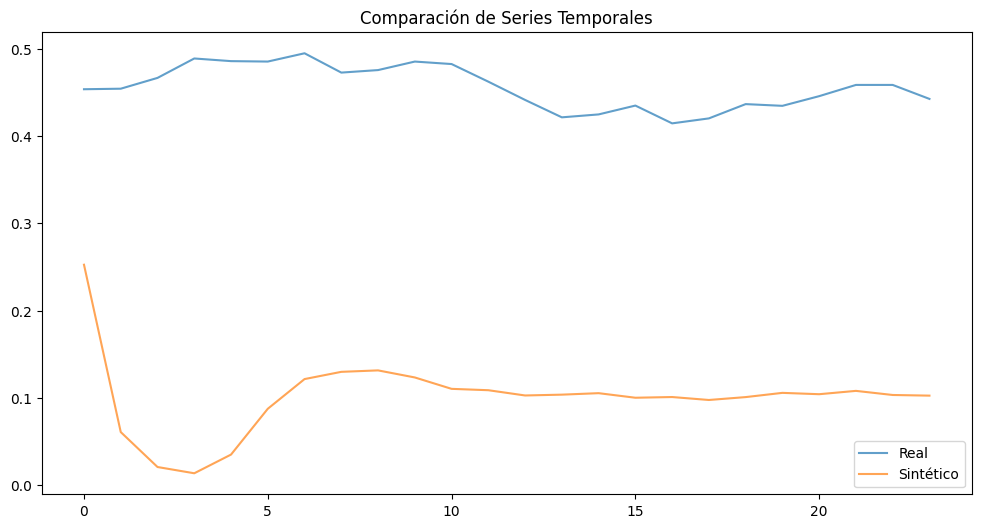

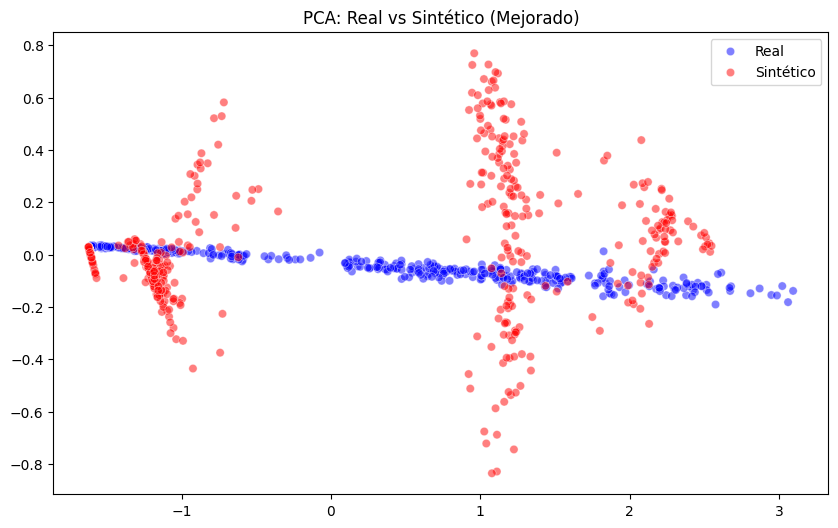

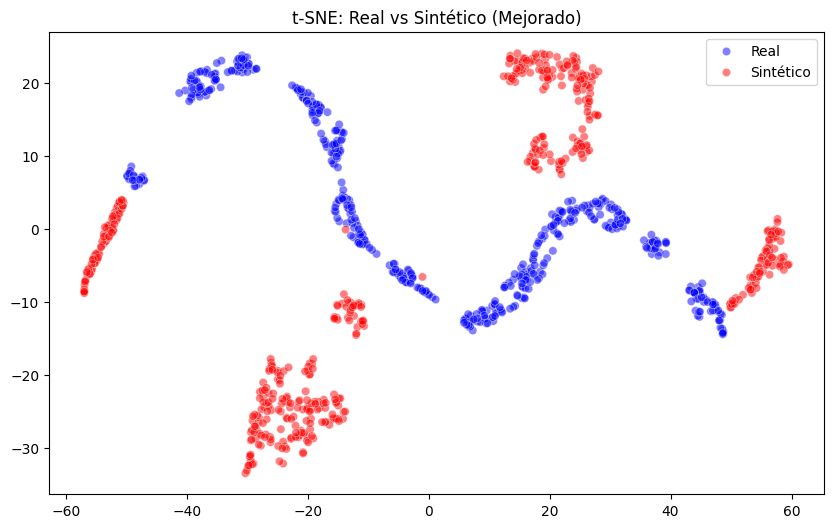

In [6]:
# 1. Gráfica de Pérdidas
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.title("Curvas de Aprendizaje (Improved GAN)")
plt.legend()
plt.show()

# 2. Generar datos para evaluación
num_eval_samples = 500
generator.eval()
with torch.no_grad():
    z = torch.randn(num_eval_samples, SEQ_LEN, NOISE_DIM).to(device)
    synthetic_data = generator(z).cpu().numpy().squeeze()

# Tomar muestras reales
indices = np.random.choice(len(sequences), num_eval_samples, replace=False)
real_samples = sequences[indices].squeeze()

# 3. Comparación Visual de Series
plt.figure(figsize=(12, 6))
plt.plot(real_samples[0], label="Real", alpha=0.7)
plt.plot(synthetic_data[0], label="Sintético", alpha=0.7)
plt.title("Comparación de Series Temporales")
plt.legend()
plt.show()

# 4. PCA
combined_data = np.concatenate([real_samples, synthetic_data], axis=0)
labels = np.array(['Real'] * num_eval_samples + ['Sintético'] * num_eval_samples)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=labels, alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title("PCA: Real vs Sintético (Mejorado)")
plt.show()

# 5. t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(combined_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title("t-SNE: Real vs Sintético (Mejorado)")
plt.show()

In [ ]:
# Guardar modelo mejorado
save_path = "../models/generator_improved.pth"
torch.save(generator.state_dict(), save_path)
print(f"Modelo mejorado guardado en: {save_path}")